# Imports

In [2]:
pip install xgboost

In [3]:
import requests
import csv
from bs4 import BeautifulSoup
import yfinance as yf
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import math
import warnings
warnings.simplefilter("ignore", UserWarning)
import xgboost as xgb
import datetime

# Analytics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statistics import mean




# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio


# Data Gathering

## SP500 Tickers

In [4]:
def save_sp500_tickers():
  # Retrieves S&P 500 table from Wikipedia
  URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
  res = requests.get(URL)
  soup = BeautifulSoup(res.content, 'lxml')
  table = soup.find('table', {'class': 'wikitable sortable'})

  # Parses the table to a list of ticker symbols
  sp500tickers = []

  for row in table.findAll('tr')[1:]:
      ticker = row.findAll('td')[0].text.strip()
      sp500tickers.append(ticker)

  # Writing to csv
  filename = "sp500tickers.csv"
  with open(filename, mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['Ticker'])
      for ticker in sp500tickers:
          writer.writerow([ticker])

  return sp500tickers

In [5]:
def load_sp500_tickers():
  path = r'https://raw.githubusercontent.com/jakem08/ms2/main/sp500tickers.csv'
  df = pd.read_csv(path)
  ticker_list = df['Ticker'].tolist()

  return ticker_list


## Stock Data

https://aroussi.com/post/python-yahoo-finance

https://pypi.org/project/yfinance/

In [6]:
def save_stock_data(tickers, start_date, end_date):
  # yahoo finance bulk api call
  data = yf.download(tickers, start=start_date, end=end_date)
  open_df = data.loc[:, 'Open']
  high_df = data.loc[:, 'High']
  low_df = data.loc[:, 'Low']
  close_df = data.loc[:, 'Close']
  adj_close_df = data.loc[:, 'Adj Close']
  volume_df = data.loc[:, 'Volume']

  # yahoo finance individual stock .info
  desc_df = pd.DataFrame()
  for ticker in tqdm(tickers):
    stock_data = yf.Ticker(ticker)
    info = pd.DataFrame([stock_data.info])
    info.index = [ticker]
    desc_df = pd.concat([desc_df,info], axis=0)
    time.sleep(.1)

  # save dataframes to csv
  dataframe_list = [open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df]
  names = ['open_df', 'high_df', 'low_df', 'close_df', 'adj_close_df', 'volume_df','desc_df']

  for name, df in zip(names, dataframe_list):
    df.to_csv(f'{name}.csv', index=True)

  return open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df

In [7]:
def load_stock_data():
  names = ['open_df', 'high_df', 'low_df', 'close_df', 'adj_close_df', 'volume_df', 'desc_df']
  stock_data = {name: pd.read_csv(f'https://raw.githubusercontent.com/jakem08/ms2/main/{name}.csv',index_col=0) for name in names}
  for df in stock_data.values():
        df.fillna(method='ffill', inplace=True)
  open_df = stock_data['open_df']
  high_df = stock_data['high_df']
  low_df = stock_data['low_df']
  close_df = stock_data['close_df']
  adj_close_df = stock_data['adj_close_df']
  volume_df = stock_data['volume_df']
  desc_df = stock_data['desc_df']

  return open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df


# Save or Load Data

Save or Load Tickers

In [8]:
sp500tickers_list = load_sp500_tickers()


Save or Load Stock Data

In [9]:
open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df = load_stock_data()

# Data Cleaning


In [10]:
sp500tickers_list = [x for x in sp500tickers_list if x not in ['BF.B','BRK.B','CAT','L']]

In [11]:
adj_close_df = adj_close_df.drop(['BF.B','BRK.B'], axis=1) #drop BF.B, BRK.B; all NaNs
desc_df = desc_df.drop(['BF.B','BRK.B','CAT','L'], axis=0) #drop BF.B, BRK.B; all NaNs
adj_close_df.tail()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-23 00:00:00,119.129997,14.78,181.119995,147.080002,128.130005,105.129997,75.400002,315.339996,530.710022,176.640335,...,96.080002,57.005459,107.150002,37.779999,100.245552,128.796585,114.849998,270.089996,33.980000,184.250000
2023-08-24 00:00:00,119.489998,14.57,176.380005,146.630005,124.720001,103.750000,75.410004,314.140015,512.429993,172.868271,...,95.489998,56.500019,106.349998,37.240002,99.328522,128.935928,114.320000,265.920013,34.470001,181.559998
2023-08-25 00:00:00,119.680000,14.58,178.610001,146.690002,125.790001,104.209999,74.620003,318.760010,525.059998,177.317123,...,95.480003,57.064922,108.250000,37.529999,100.843613,129.135010,115.239998,268.390015,34.130001,182.820007
2023-08-28 00:00:00,119.919998,14.73,180.190002,147.429993,126.154999,102.790001,74.190002,320.910004,529.919983,179.476868,...,96.790001,57.332504,109.160004,37.650002,101.491516,129.309998,117.529999,269.920013,34.900002,186.979996
2023-08-29 00:00:00,122.019997,14.90,184.119995,147.589996,132.250000,103.870003,75.750000,323.450012,540.570007,181.696304,...,98.070000,57.431610,109.809998,37.790001,101.960007,128.899994,119.230003,273.489990,35.439999,192.770004


# S2: XGBoost

In [12]:
#returns the df with rolling averages and lagged values, target values as a series
def extract_feature(ticker, shift):

  close = adj_close_df[ticker]
  high = high_df[ticker]
  low = low_df[ticker]
  volume = volume_df[ticker]
  # df = hist[ticker]
  y = close.copy()
  y.dropna(inplace = True)
  df = pd.DataFrame(columns = ['Close', 'High', 'Low', 'Volume'])
  df['Close'] = close
  df['High'] = high
  df['Low'] = low
  df['Volume'] = volume
  df.index = pd.to_datetime(df.index)

  df.dropna(inplace = True)
  if len(df) == 0:
    return None, None

  df['H_L_diff'] = df['High'] - df['Low']
  df.drop(columns= ['High', 'Low'], inplace =True)
  cols = ['Close', 'Volume', 'H_L_diff']

  df_lags = df.copy()
  for col in cols:
    df_lags['Previous ' + col] = df[col].shift(shift)

  for col in cols:
    wk1_new_case = []
    wk1_rolling_mean, wk1_rolling_std = [], []
    for val in df[col]:
      if len(wk1_new_case) < 5:
        wk1_new_case.append(val)
        wk1_rolling_mean.append(np.mean(np.array(wk1_new_case)))
        wk1_rolling_std.append(np.std(np.array(wk1_new_case)))
      else:
        wk1_new_case.append(val)
        test = wk1_new_case[-5:].copy()
        wk1_rolling_mean.append(np.mean(np.array(test)))
        wk1_rolling_std.append(np.std(np.array(test)))

    df_lags[col + ' 1 Week Avg'] = wk1_rolling_mean
    df_lags[col + ' 1 Week St.Dev.'] = wk1_rolling_std

    df_lags[col + ' 1 Week Avg'] = df_lags[col + ' 1 Week Avg'].shift(shift)
    df_lags[col + ' 1 Week St.Dev.'] = df_lags[col + ' 1 Week St.Dev.'].shift(shift)

  df_lags.drop(columns= cols, inplace =True)

  return df_lags, y

In [13]:
def run_xgboost(tickers, lags, test_size, splits):
  from sklearn.metrics import mean_absolute_percentage_error
  scores_df = pd.DataFrame(columns=['n_estimators', 'max_depth', 'learning_rate', 'RMSE Avg.', 'RMSE Std.', 'MAPE Avg.', 'MAPE Std.', 'Accuracy'])
#loop over every ticker
  for ticker in tqdm(tickers):
    print(ticker)
#for eah day we want to forecast, we shift the data by that many days
    df, y = extract_feature(ticker, lags)
    if df is None:
      continue
#create scaler for the features and one for the target
    feat_scaler = StandardScaler()
    tar_scaler = StandardScaler()
#fit and transform features and targets
    std_sc_feat = pd.DataFrame(feat_scaler.fit_transform(df), index = df.index, columns = df.columns)
    std_sc_tar =  pd.DataFrame(tar_scaler.fit_transform(y.values.reshape(-1,1)), index = y.index)
# hyper parameters to tune
    n_estimators = [50, 100, 200, 500]
    max_depth = [3, 4, 5, 8]
    learning_rate = [0.01, 0.1, 0.2, .3]

#loop through all hyperparameters
#split_size is used for cross-validation
#for each fold we use one consecutive chunk of our data and the last day is the test set that we are predicting
    split_size = int(len(df)/splits)

    best_model = None
    accuracy = 0
    for estimator in n_estimators:
      for depth in max_depth:
        for rate in learning_rate:
          rmse = []
          mape = []
          direction_accuracy = []
          # TEST preds = []
#for each set of hyper-parameters, use cross-validation to determine the best hyperparameters per model
          for split in range(splits):
            split_start = 0 + split_size*split
            split_end = split_size + split_size*split

#get train and test sets
            X_train = std_sc_feat[split_start : split_end-test_size]
            X_test  = std_sc_feat[split_end-test_size:split_end]

            y_train = std_sc_tar[split_start : split_end-test_size]
            y_test = std_sc_tar[split_end-test_size:split_end]

#create and fit XGBRegressor
            reg = xgb.XGBRegressor(n_estimators = estimator, max_depth = depth, learning_rate = rate, seed = 42)
            reg.fit(X_train, y_train)
# #get predictions, inverse scaler to get actual values
            predictions_scaled = reg.predict(X_test)
            predictions = tar_scaler.inverse_transform(predictions_scaled.reshape(-1,1))

# #Calculate RMSE and MAPE and store in list
            rmse_score = np.sqrt(np.mean(predictions - y[split_end-test_size:split_end].values)**2)
            mape_score = mean_absolute_percentage_error(y[split_end-test_size:split_end].values, predictions)

            rmse.append(rmse_score)
            mape.append(mape_score)
#determine if prediction and actual were both above or below previous stock price, moving in correct direction
            prev_price = y[split_end-test_size-1:split_end-1].values
            actual_price = y[split_end-test_size:split_end].values
            for day in range(test_size):
              if ((predictions[day] >= prev_price[day]) and (actual_price[day] >= prev_price[day])) or ((predictions[day] < prev_price[day]) and (actual_price[day] < prev_price[day])):
                direction_accuracy.append(1)
              else:
                direction_accuracy.append(0)

#update best scores and hyper parameters
          if accuracy == 0:
            cv_rmse_score = np.average(rmse)
            cv_mape_score = np.average(mape)
            best_model = (estimator, depth, rate)
            cv_rmse_std = np.std(rmse)
            cv_mape_std = np.std(mape)
            accuracy = np.average(direction_accuracy)

          elif accuracy < np.average(direction_accuracy):
            cv_rmse_score = np.average(rmse)
            cv_mape_score = np.average(mape)
            best_model = (estimator, depth, rate)
            cv_rmse_std = np.std(rmse)
            cv_mape_std = np.std(mape)
            accuracy = np.average(direction_accuracy)

#once each hyper parameter has gone through cross validation, report the best scores and add to dataframe
    new_row = pd.DataFrame({'n_estimators': best_model[0], 'max_depth': best_model[1], 'learning_rate': best_model[2],
                            'RMSE Avg.' : cv_rmse_score, 'RMSE Std.' : cv_rmse_std,
                            'MAPE Avg.' : cv_mape_score, 'MAPE Std.' : cv_mape_std,
                            'Accuracy': accuracy}, index = [ticker])
    scores_df = pd.concat([scores_df, new_row],ignore_index = False)

  return scores_df


In [14]:
#ticker_scores = run_xgboost(sp500tickers_list[:5], 1, 5, 5)

In [15]:
#ticker_scores

In [16]:
#ticker_scores.to_csv('xgb_results.csv')

In [17]:
def load_xgb_scores():
  names = ['xgb_results']
  stock_data = {name: pd.read_csv(f'https://raw.githubusercontent.com/jakem08/ms2/main/{name}.csv',index_col=0) for name in names}
  for df in stock_data.values():
        df.fillna(method='ffill', inplace=True)
  xgb_df = stock_data['xgb_results']


  return xgb_df

xgb_results = load_xgb_scores()
xgb_results.sort_values('Accuracy', inplace = True)
xgb_results

,n_estimators,max_depth,learning_rate,RMSE Avg.,RMSE Std.,MAPE Avg.,MAPE Std.,Accuracy
CPB,500,4,0.01,0.786229,0.293211,0.017585,0.006391,0.16
BX,50,3,0.20,1.455940,1.281311,0.021853,0.011318,0.28
MKTX,100,8,0.30,8.584543,9.467168,0.027390,0.021843,0.28
A,500,3,0.10,2.947717,3.134332,0.026922,0.014416,0.28
OGN,500,4,0.01,1.031798,0.808516,0.037588,0.033182,0.28
...,...,...,...,...,...,...,...,...
SPGI,50,3,0.20,2.695897,1.426186,0.009504,0.005078,0.76
ANSS,500,4,0.10,2.907888,1.053375,0.012682,0.007389,0.80
VRTX,100,4,0.10,2.531864,1.118617,0.011754,0.007826,0.80
DGX,200,4,0.20,0.714855,0.535122,0.007853,0.008691,0.80


#Evaluation Analysis

##Feature Importance

In [18]:
def xgb_feature_importance(ticker, lags):
  print(ticker)
  df, y = extract_feature(ticker, lags)
  if df is None:
    return None
#create scaler for the features and one for the target
  feat_scaler = StandardScaler()
  tar_scaler = StandardScaler()
#fit and transform features and targets
  std_sc_feat = pd.DataFrame(feat_scaler.fit_transform(df), index = df.index, columns = df.columns)
  std_sc_tar =  pd.DataFrame(tar_scaler.fit_transform(y.values.reshape(-1,1)), index = y.index)
# use best hyperparameters based on cross validation evaluation
  n_estimators = int(xgb_results.loc[ticker]['n_estimators'])
  max_depth = int(xgb_results.loc[ticker]['max_depth'])
  learning_rate = xgb_results.loc[ticker]['learning_rate']

#get train and test sets
  X_train = std_sc_feat[:-5]
  X_test  = std_sc_feat[-5:]

  y_train = std_sc_tar[:-5]
  y_test = std_sc_tar[-5:]

#create and fit XGBRegressor
  reg = xgb.XGBRegressor(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, seed = 42)
  reg.fit(X_train, y_train)
# plot the importance of each variable in X_train
  xgb.plot_importance(reg, title = 'Feature Importance ' + ticker, grid = False)
  plt.number = 1
  return plt.show()


In [19]:
#Test to make sure it worked on each stock
tickers = xgb_results.index

# for ticker in tqdm(tickers[:5]):
#     xgb_feature_importance(ticker, 1)

GPN


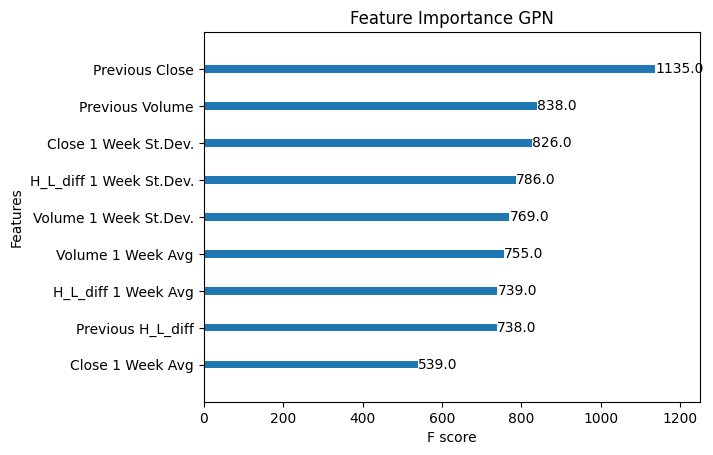

In [20]:
xgb_feature_importance('GPN', 1)

CPB


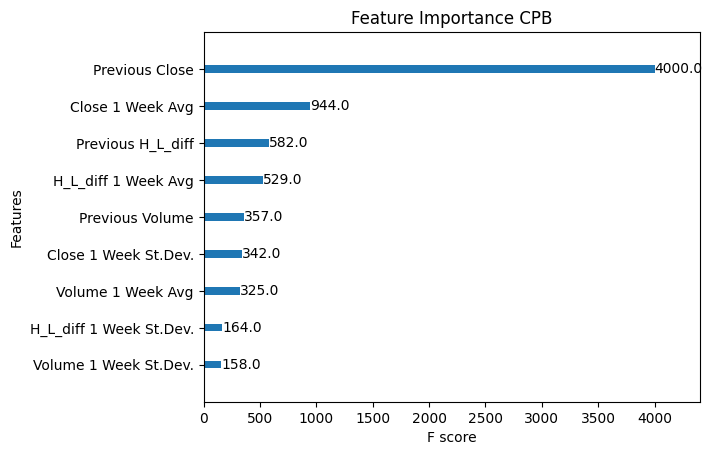

In [21]:
xgb_feature_importance('CPB', 1)

##Sensitivity Analysis

In [22]:
def xgb_sensitivity(ticker, lags, test_size, splits):
  from sklearn.metrics import mean_absolute_percentage_error
  scores_df = pd.DataFrame(columns=['n_estimators', 'max_depth', 'learning_rate', 'RMSE Avg.', 'RMSE Std.', 'MAPE Avg.', 'MAPE Std.', 'Accuracy'])
  print(ticker)
  df, y = extract_feature(ticker, lags)
  if df is None:
    return None
#create scaler for the features and one for the target
  feat_scaler = StandardScaler()
  tar_scaler = StandardScaler()
#fit and transform features and targets
  std_sc_feat = pd.DataFrame(feat_scaler.fit_transform(df), index = df.index, columns = df.columns)
  std_sc_tar =  pd.DataFrame(tar_scaler.fit_transform(y.values.reshape(-1,1)), index = y.index)
# hyper parameters to tune
  n_estimators = [50, 100, 200, 500]
  max_depth = [3, 4, 5, 8]
  learning_rate = [0.01, .05, 0.1, 0.2, .3]

#loop through all hyperparameters
#split_size is used for cross-validation
#for each fold we use one consecutive chunk of our data
  split_size = int(len(df)/splits)

  best_model = None
  accuracy = 0
  for estimator in n_estimators:
    for depth in max_depth:
      for rate in learning_rate:
        rmse = []
        mape = []
        direction_accuracy = []
          # TEST preds = []
#for each set of hyper-parameters, use cross-validation to determine the best hyperparameters per model
        for split in range(splits):
          split_start = 0 + split_size*split
          split_end = split_size + split_size*split

#get train and test sets
          X_train = std_sc_feat[split_start : split_end-test_size]
          X_test  = std_sc_feat[split_end-test_size:split_end]

          y_train = std_sc_tar[split_start : split_end-test_size]
          y_test = std_sc_tar[split_end-test_size:split_end]

#create and fit XGBRegressor
          reg = xgb.XGBRegressor(n_estimators = estimator, max_depth = depth, learning_rate = rate, seed = 42)
          reg.fit(X_train, y_train)
# #get predictions, inverse scaler to get actual values
          predictions_scaled = reg.predict(X_test)
          predictions = tar_scaler.inverse_transform(predictions_scaled.reshape(-1,1))

# #Calculate RMSE and MAPE and store in list
          rmse_score = np.sqrt(mean_squared_error(y[split_end-test_size:split_end].values, predictions))
          mape_score = mean_absolute_percentage_error(y[split_end-test_size:split_end].values, predictions)

          rmse.append(rmse_score)
          mape.append(mape_score)
#determine if prediction and actual were both above or below previous stock price, moving in correct direction
          prev_price = y[split_end-test_size-1:split_end-1].values
          actual_price = y[split_end-test_size:split_end].values
          for day in range(test_size):
            if ((predictions[day] >= prev_price[day]) and (actual_price[day] >= prev_price[day])) or ((predictions[day] < prev_price[day]) and (actual_price[day] < prev_price[day])):
              direction_accuracy.append(1)
            else:
              direction_accuracy.append(0)

#update best scores and hyper parameters

        cv_rmse_score = np.average(rmse)
        cv_mape_score = np.average(mape)
        best_model = (estimator, depth, rate)
        cv_rmse_std = np.std(rmse)
        cv_mape_std = np.std(mape)
        accuracy = np.average(direction_accuracy)

#once each hyperparameter has gone through cross validation, report the best scores and add to dataframe
        new_row = pd.DataFrame({'n_estimators': best_model[0], 'max_depth': best_model[1], 'learning_rate': best_model[2],
                                'RMSE Avg.' : cv_rmse_score, 'RMSE Std.' : cv_rmse_std,
                                'MAPE Avg.' : cv_mape_score, 'MAPE Std.' : cv_mape_std,
                                'Accuracy': accuracy}, index = [ticker])
        scores_df = pd.concat([scores_df, new_row],ignore_index = False)

  return scores_df

In [23]:
test = xgb_sensitivity('CPB', 1, 5, 5)

CPB


In [24]:
test.sort_values(by = 'Accuracy')

,n_estimators,max_depth,learning_rate,RMSE Avg.,RMSE Std.,MAPE Avg.,MAPE Std.,Accuracy
CPB,100,5,0.05,0.828395,0.255590,0.018667,0.005891,0.12
CPB,50,5,0.10,0.827877,0.251854,0.018747,0.005925,0.12
CPB,500,5,0.01,0.804424,0.282628,0.018131,0.006566,0.16
CPB,500,4,0.01,0.786229,0.293211,0.017585,0.006391,0.16
CPB,50,8,0.05,0.936317,0.340135,0.021054,0.007499,0.16
...,...,...,...,...,...,...,...,...
CPB,100,3,0.01,1.503322,0.526084,0.034043,0.013615,0.44
CPB,50,8,0.01,2.292961,0.640268,0.054443,0.016047,0.44
CPB,50,5,0.01,2.296739,0.640218,0.054549,0.016073,0.44
CPB,50,4,0.01,2.290385,0.636378,0.054393,0.015984,0.44


In [34]:
chart = go.Figure(data =
 [go.Scatter3d(
    x=test['n_estimators'], y=test['max_depth'], z=test['learning_rate'], mode = 'markers',
                                   marker = dict(size = 5, color = test['Accuracy'], colorscale = 'rainbow', colorbar = dict(title = 'Performance')))])


chart.update_layout(scene=dict(aspectmode='cube',
                             xaxis_title='# of n_estimators', yaxis_title='Max Depth', zaxis_title='Learning Rate'),
                  title = {'text': 'XGBoost Model Performance for each Hyper Parameter',
                           'x': .5,
                           'y': .9},
                  width = 800, height = 800)
chart.add_annotation( text = 'Plot shows Accuracy Scores for CPB stock', x = .5, y= 1, showarrow = False)

# Show the plot
chart.show()

In [35]:
chart = go.Figure(data =
 [go.Scatter3d(
    x=test['n_estimators'], y=test['max_depth'], z=test['learning_rate'], mode = 'markers',
                                   marker = dict(size = 5, color = test['MAPE Avg.'], colorscale = 'rainbow_r', colorbar = dict(title = 'Performance')))])

# Customize the layout (if needed)
chart.update_layout(scene=dict(aspectmode='cube',
                             xaxis_title='# of n_estimators', yaxis_title='Max Depth', zaxis_title='Learning Rate'),
                  title = {'text': 'XGBoost Model Performance for each Hyper Parameter',
                           'x': .5,
                           'y': .9},
                  width = 800, height = 800)
chart.add_annotation( text = 'Plot shows Average MAPE Scores for CPB stock', x = .5, y= 1, showarrow = False)
# Show the plot
chart.show()

##Failure Analysis

In [27]:
def save_test_data(tickers, start_date, end_date):
  # yahoo finance bulk api call
  data = yf.download(tickers, start=start_date, end=end_date)
  high_df = data.loc[:, 'High']
  low_df = data.loc[:, 'Low']
  adj_close_df = data.loc[:, 'Adj Close']
  volume_df = data.loc[:, 'Volume']

  # yahoo finance individual stock .info


  # save dataframes to csv
  dataframe_list = [high_df, low_df, adj_close_df, volume_df]
  names = ['high_df', 'low_df','adj_close_df', 'volume_df']

  for name, df in zip(names, dataframe_list):
    df.to_csv(f'{name}.csv', index=True)

  return high_df, low_df, adj_close_df, volume_df
high_test_df, low_test_df, adj_close_test_df, volume_test_df = save_test_data(sp500tickers_list, '2023-09-01', '2023-10-14')

[*********************100%%**********************]  499 of 499 completed


In [28]:
high_df = pd.concat([high_df, high_test_df], sort=False)
low_df = pd.concat([low_df, low_test_df], sort=False)
adj_close_df = pd.concat([adj_close_df, adj_close_test_df], sort=False)
volume_df = pd.concat([volume_df, volume_test_df], sort=False)


In [29]:
def xgb_failure_analysis(ticker, lags, figure, save_preds = False):

#for eah day we want to forecast, we shift the data by that many days
  df, y = extract_feature(ticker, lags)
  if df is None:
    return None
#create scaler for the features and one for the target
  feat_scaler = StandardScaler()
  tar_scaler = StandardScaler()
#fit and transform features and targets
  std_sc_feat = pd.DataFrame(feat_scaler.fit_transform(df), index = df.index, columns = df.columns)
  std_sc_tar =  pd.DataFrame(tar_scaler.fit_transform(y.values.reshape(-1,1)), index = y.index)
# hyper parameters to tune
  n_estimators = int(xgb_results.loc[ticker]['n_estimators'])
  max_depth = int(xgb_results.loc[ticker]['max_depth'])
  learning_rate = xgb_results.loc[ticker]['learning_rate']

#get train and test sets
  X_train = std_sc_feat[ :-30]
  X_test  = std_sc_feat[-30:]

  y_train = std_sc_tar[: -30]
  y_test = std_sc_tar[-30:]

#create and fit XGBRegressor
  reg = xgb.XGBRegressor(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, seed = 42)
  reg.fit(X_train, y_train)
# #get predictions, inverse scaler to get actual values
  predictions_scaled = reg.predict(X_test)
  predictions = tar_scaler.inverse_transform(predictions_scaled.reshape(-1,1))

# #Calculate RMSE and MAPE and store in list
  prev_price = y[-31:-1].values
  actual_price = y[-30:].values
  direction_accuracy = []
  for day in range(len(X_test)):
    if ((predictions[day] >= prev_price[day]) and (actual_price[day] >= prev_price[day])) or ((predictions[day] < prev_price[day]) and (actual_price[day] < prev_price[day])):
      direction_accuracy.append(1)
    else:
      direction_accuracy.append(0)

  print(np.average(direction_accuracy))

  predictions = [x[0] for x in predictions]
  test = pd.Series(data = predictions, index = X_test.index)
  if save_preds is True:
    test.to_csv('predictions.csv', index = True)

  chart = go.Figure()

  chart.add_trace(go.Scatter(x = df.index[-40:], y = y[-40:], mode = 'lines', name = 'Actual Stock Prices'))
  chart.add_trace(go.Scatter(x = X_test.index, y = predictions, mode = 'lines', name = 'Predicted Stock Prices'))

  chart.update_layout(title = {'text': 'Actual vs Predicted Stock Prices for ' + ticker,
                           'x': .5,
                           'y': .8}, xaxis_title = 'Date', yaxis_title = 'Stock Price in USD',
                      width = 500, height = 400,
                      legend = dict(x=.02, y=.02))

  return chart.show()


In [30]:
xgb_failure_analysis('AAPL', 1, 6)

0.5333333333333333


In [ ]:
xgb_failure_analysis('SEDG', 1, 6)

In [ ]:
xgb_failure_analysis('CPB', 1, 6)